In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils

# Prep Traffic Data

In [2]:
# df = utils.load_csv('../*2019.csv')

In [3]:
# df = df.dropna()
# df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [4]:
# df['Speed_norm'] = 0
# for group in df.groupby('Id'):
#     df_tem = group[1]
#     df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
#     df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']

In [5]:
# df.to_csv('traffic_data_clean.csv')

In [6]:
df = pd.read_csv('traffic_data_clean.csv')
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])
df = df[['Id','Speed_norm','DataAsOf']]
df.head()

,Id,Speed_norm,DataAsOf
0,1,-0.776763,2019-02-01 01:58:11
1,106,-1.511565,2019-02-01 01:58:11
2,110,0.327143,2019-02-01 01:58:04
3,119,-2.081642,2019-02-01 01:58:03
4,124,-1.117963,2019-02-01 01:58:03


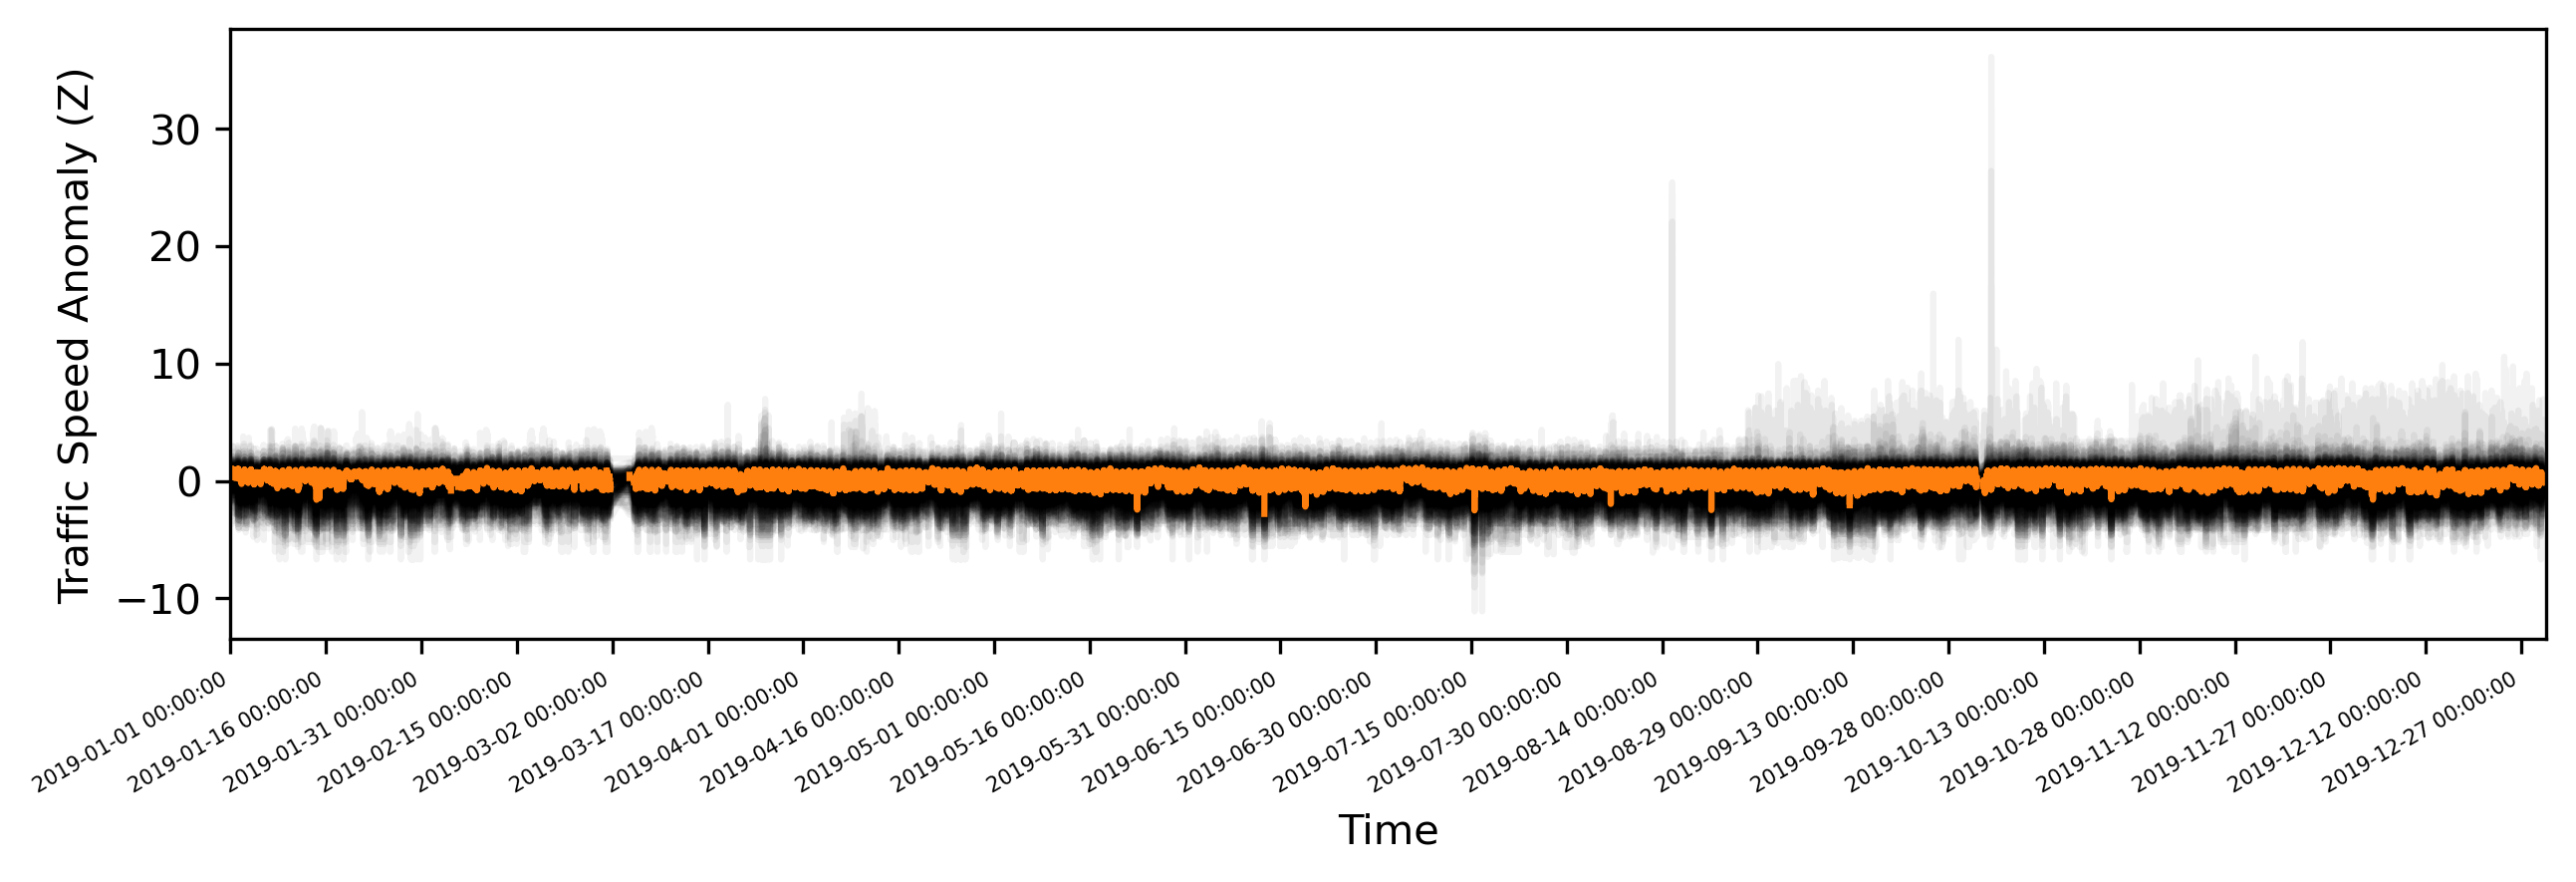

In [7]:
start = '2019-01-01'
end = '2019-12-31'

df_rs = utils.plot_traffic_speed(df,start,end,figsize = (10,3),ticks='15D')

### Remove days where we have less than 80% of sensors working 
If too many sensors are down, the median response won't represent the whole city

In [8]:
sensor_outage = df_rs.isna().sum(axis=1)
tol = 28

cond_keep = sensor_outage<tol
cond_toss = sensor_outage>tol

speed_ts = df_rs.median(axis=1)

speed_ts[cond_toss] = np.nan

### Visualize removal of days with %20 of sensors malfunctioning

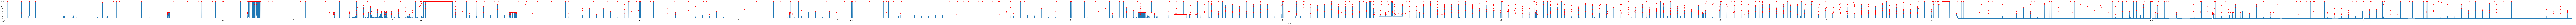

In [13]:
plt.figure(figsize = (400,3))
df_rs.isna().sum(axis=1).plot(xlim=('2019-01-01','2019-12-31'))
plt.scatter(df_rs.isna().sum(axis=1)[cond_toss].index,
            df_rs.isna().sum(axis=1)[cond_toss],c='r',zorder=20)

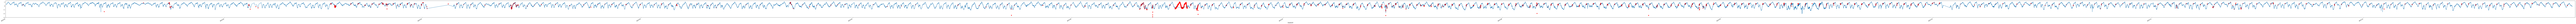

In [14]:
plt.figure(figsize = (400,3))
df_rs.median(axis=1)[cond_keep].plot(xlim=('2019-01-01','2019-12-31'))

plt.scatter(df_rs.median(axis=1)[cond_toss].index,
            df_rs.median(axis=1)[cond_toss],c='r')

### Interpolate over na values if less than 3 consecutive (15 minutes) na values

In [9]:
speed_ts.interpolate(method='linear',limit=3)

DataAsOf
2019-01-01 02:00:00    0.319319
2019-01-01 02:05:00    0.310966
2019-01-01 02:10:00    0.328083
2019-01-01 02:15:00    0.345164
2019-01-01 02:20:00    0.328083
                         ...   
2019-12-30 13:30:00   -0.095564
2019-12-30 13:35:00   -0.102386
2019-12-30 13:40:00   -0.131715
2019-12-30 13:45:00   -0.146489
2019-12-30 13:50:00   -0.078790
Freq: 5T, Length: 104687, dtype: float64

### A normal day

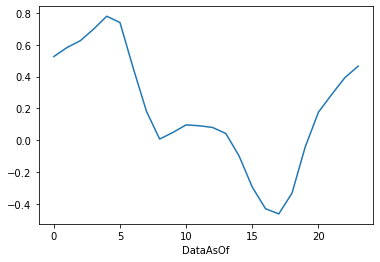

In [10]:
speed_ts.groupby(df_rs.index.hour).mean().plot()

# Prep Weather Data

download weather data via api request

In [ ]:
baseurl='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?'

request = 'station=NYC\
&data=tmpf&data=dwpf&data=p01i&data=\
&year1=2019&month1=1&day1=1&year2=2019&month2=12&day2=31&tz=Etc%2FUTC\
&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'

df_weather = pd.read_csv(f'{baseurl}{request}',na_values=['M'])

In [11]:
# small amounts of precip are marked at T (trace)
df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001
df_weather['p01i'] = df_weather['p01i'].astype(float)

# set datetime index and make sure only these columns are in the data ['time','tmpf','dwpf','p01i']
df_weather['time'] = pd.to_datetime(df_weather['valid'])
df_weather = df_weather[['time','tmpf','dwpf','p01i']]
df_weather = df_weather.set_index('time')

#drop na values and resample
df_weather = df_weather.dropna()
df_weather = df_weather.resample('5min').pad()

<ipython-input-11-a86b9cdecd46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001


In [22]:
df_norm = df_weather
df_norm['speed'] = speed_ts

In [23]:
means = df_norm.mean()
stds = df_norm.std()
df_norm = (df_norm - means)/stds

df_norm['p01i'] = ((df_weather['p01i'])**(1/3))*2 # cubic normalization for these data

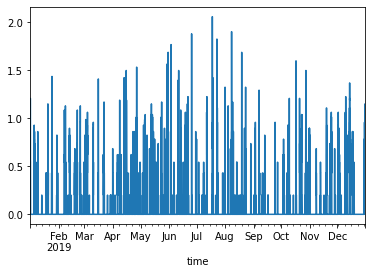

In [24]:
df_norm['p01i'].plot()

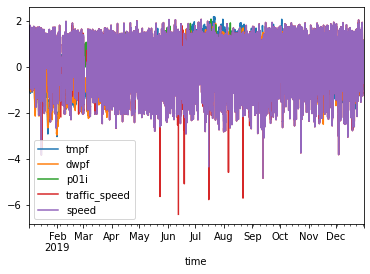

In [25]:
df_norm.plot()

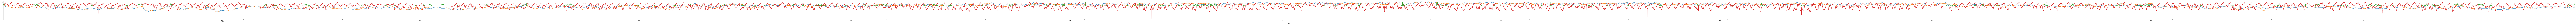

In [20]:
plt.figure(figsize = (400,3))

for item in df_norm.columns:
    df_norm[item].plot()

In [26]:
df_norm.to_csv('df_norm.csv')